# Lab 3: Rigid Registration


## Goals of this lab
The aim of this lab is to develop competences regarding teamwork and problem solving. By developing the proposed activity you will also become familiar with SIFT and planar transformations for rigid image registration: how to extract invariant features, how to describe them, how to match them and how to use them to compute a homography. Most importantly, this should give you some feeling about the strengths and weaknesses of local feature-based approaches.
It should be noted that before you start this activity, you should read Lowe’s paper on SIFT:

David G. Lowe, "Distinctive image features from scale-invariant keypoints," International Journal of Computer Vision, 60, 2 (2004), pp. 91-110.
The paper can be downloaded from [here](http://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf).

This lab requires working in teams of two (exceptionally three) students. The labs will be organized on the first lab session by the professor who acts as lab instructor.

Students will have to:

1. Test Lowe’s implementation on a set of images showing some skin lesions.
2. Register the images pairs corresponding to the same skin lesion using Lowe’s implementation to detect and match features, and implementing different motion models by estimating homography matrices.
3. Improve the registration accuracy by means of data normalization for the homography estimation.

## Additional tools
In this lab, we will also make use of:
- NumPy, a popular library for scientific computing
- Matplotlib, a popular library for plotting data
- Routines in the aux_utils.py file, which should already be in the local directory
- Opencv
-...

In [2]:
import math, copy
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#from aux_utils import plt_house_x, plt_contour_wgrad, plt_gradients, plt_cost_vs_theta1
# from google.colab import files
# import time
from IPython import display
from time import sleep
# import opencv
import cv2
# from google.colab.patches import cv2_imshow

import pandas as pd
import io

#Import math Library
import math
import scipy.linalg as linalg

/var/folders/rg/2t9xl9h93wjdygv93x4f6s4r0000gn/T/ipykernel_31120/1013059898.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
%cd ./data

/Users/huytrq/Workspace/UdG/MIRA/Lab3/Rigid Registration/data


## Detect SIFT Keypoints and Descriptors
Now we will register real images.

Register skin1.png with skin2.png

First, load and show the images.

Also set SIFT to detect keypoints on images


In [8]:
skin_1 = cv2.imread("skin1.png")
skin_1 = cv2.cvtColor(skin_1, cv2.COLOR_BGR2RGB)
skin_2 = cv2.imread("skin2.png")
skin_2 = cv2.cvtColor(skin_2, cv2.COLOR_BGR2RGB)

## Plot the Keypoints

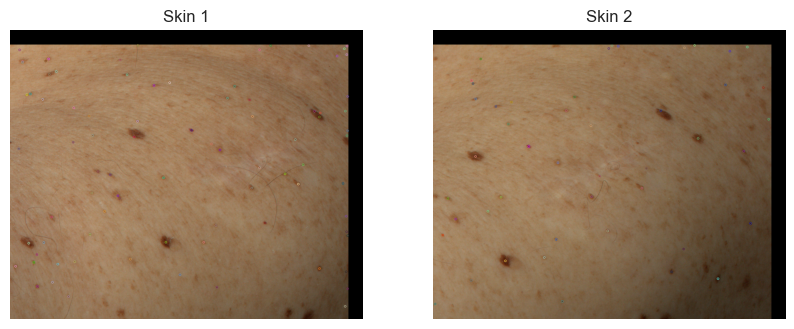

In [9]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(skin_1,None)
kp2, des2 = sift.detectAndCompute(skin_2,None)

### Visualize the keypoints
img1 = cv2.drawKeypoints(skin_1, kp1, None)
img2 = cv2.drawKeypoints(skin_2, kp2, None)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img1)
plt.title("Skin 1")
plt.axis('off')
plt.subplot(122)
plt.imshow(img2)
plt.title("Skin 2")
plt.axis('off')
plt.show()

## Compute Brute Force Matching

In [10]:
# Create a BFMatcher object.
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

Plot matches

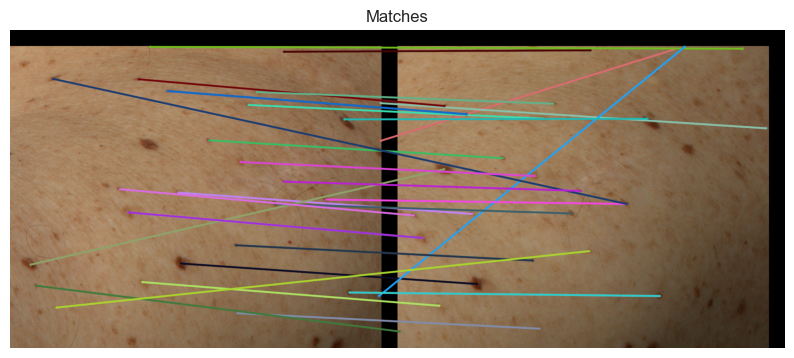

In [11]:
img3 = cv2.drawMatches(skin_1,kp1,skin_2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, matchesThickness=3)

plt.figure(figsize=(10,10))
plt.imshow(img3)
plt.title("Matches")
plt.axis('off')
plt.show()

## Lowe match

Now implement by yourself a function to match keypoints and descriptors between these 2 images

Implement the function `SIFT_match` following the article "Distinctive image features from scale-invariant keypoints" David G. Lowe.

In [12]:
def SIFT_match(des1, des2):
    # Create a BFMatcher object.
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    # Match descriptors.
    matches = bf.knnMatch(des1,des2,k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
        ## m is the closest match, n is the second closest match
        if m.distance < 0.75*n.distance:
            good.append([m])
    return good

In [13]:
matched_keypoints = SIFT_match(des1, des2)

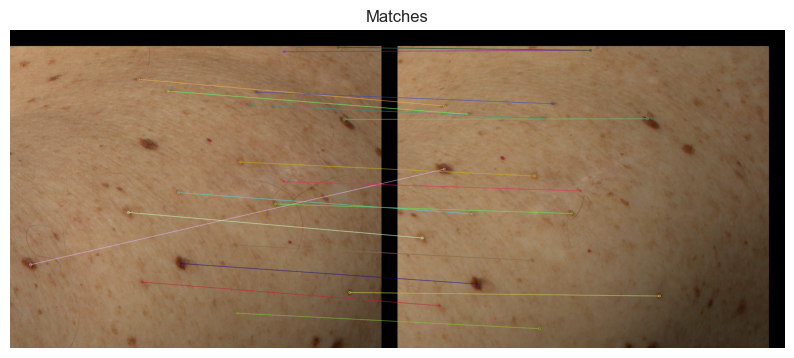

In [14]:
# cv2.drawMatchesKnn expects list of lists as matches.
img4 = cv2.drawMatchesKnn(skin_1,kp1,skin_2,kp2,matched_keypoints,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10,10))
plt.imshow(img4)
plt.title("Matches")
plt.axis('off')
plt.show()

## Compute Homographies

Compute the homography between both images using opencv function `cv2.findHomography`

Plot one of the images warped acording to the obtained Homograhy

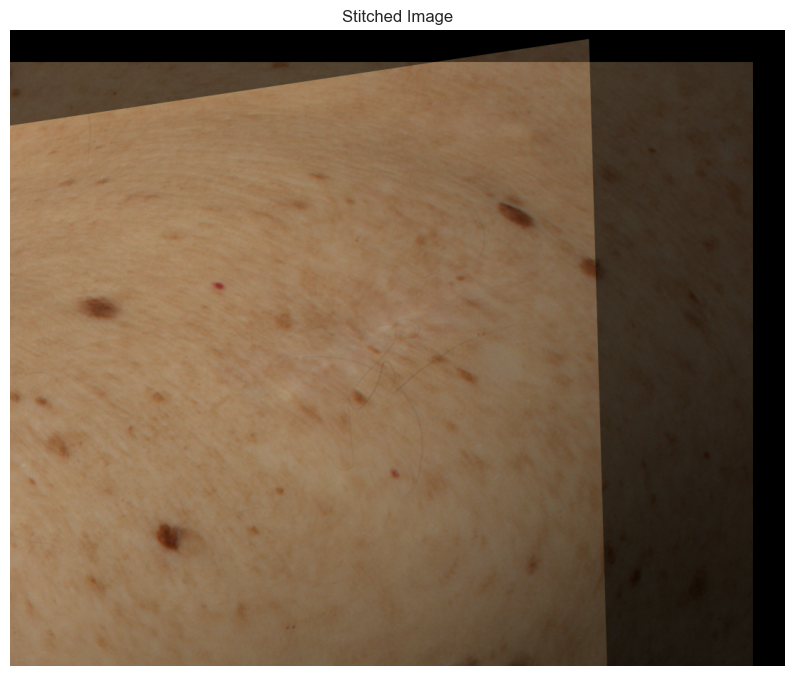

In [15]:
# Compute the homography matrix
src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in matched_keypoints ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in matched_keypoints ]).reshape(-1,1,2)
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
# Use the homography matrix to warp the images
h,w = skin_1.shape[:2]
warped = cv2.warpPerspective(skin_1, H, (w, h))
# Combine the two images
result = cv2.addWeighted(warped, 0.5, skin_2, 0.5, 0)
plt.figure(figsize=(10,10))
plt.imshow(result)
plt.title("Stitched Image")
plt.axis('off')
plt.show()


## Homography estimation

Next, we will load images `00.png`, `01.png`, `02.png` and `03.png`

In [51]:
img00c = cv2.imread("00.png")
img01c = cv2.imread("01.png")
img02c = cv2.imread("02.png")
img03c = cv2.imread("03.png")

And the csv files with keypoints

In [52]:
keypoints_00 = genfromtxt('Keypoints_00.csv', delimiter=',', skip_header = 0)
keypoints_01 = genfromtxt('Keypoints_01.csv', delimiter=',', skip_header = 0)
keypoints_02 = genfromtxt('Keypoints_02.csv', delimiter=',', skip_header = 0)
keypoints_03 = genfromtxt('Keypoints_03.csv', delimiter=',', skip_header = 0)

print(np.shape(keypoints_00))
print(keypoints_00)

(64, 2)
[[1266.3   232.7 ]
 [1266.3   320.63]
 [1266.3   407.7 ]
 [1266.3   495.64]
 [1266.3   582.7 ]
 [1266.3   670.63]
 [1266.3   757.7 ]
 [1266.3   845.63]
 [1178.4   232.7 ]
 [1178.5   320.5 ]
 [1178.5   408.  ]
 [1178.5   495.5 ]
 [1178.5   583.  ]
 [1178.5   670.5 ]
 [1178.5   758.  ]
 [1178.3   845.65]
 [1091.3   232.7 ]
 [1091.    320.5 ]
 [1091.    408.  ]
 [1091.    495.5 ]
 [1091.    583.  ]
 [1091.    670.5 ]
 [1091.    758.  ]
 [1091.3   845.63]
 [1003.4   232.7 ]
 [1003.5   320.5 ]
 [1003.5   408.  ]
 [1003.5   495.5 ]
 [1003.5   583.  ]
 [1003.5   670.5 ]
 [1003.5   758.  ]
 [1003.3   845.65]
 [ 916.3   232.7 ]
 [ 916.    320.5 ]
 [ 916.    408.  ]
 [ 916.    495.5 ]
 [ 916.    583.  ]
 [ 916.    670.5 ]
 [ 916.    758.  ]
 [ 916.3   845.64]
 [ 828.37  232.7 ]
 [ 828.5   320.5 ]
 [ 828.5   407.99]
 [ 828.5   495.5 ]
 [ 828.5   583.  ]
 [ 828.5   670.5 ]
 [ 828.5   758.  ]
 [ 828.35  845.65]
 [ 741.3   232.7 ]
 [ 741.    320.5 ]
 [ 741.    408.  ]
 [ 741.    495.5 ]
 [ 7

Now plot img00c, img01c, img02c, img03c all images using `cv2_imshow` from `opencv`

In [53]:
cv2.imshow("00", img00c)
cv2.imshow("01", img01c)
cv2.imshow("02", img02c)
cv2.imshow("03", img03c)

if cv2.waitKey(0) & ord('q'): 
    cv2.destroyAllWindows()

Plot Keypoints on images.

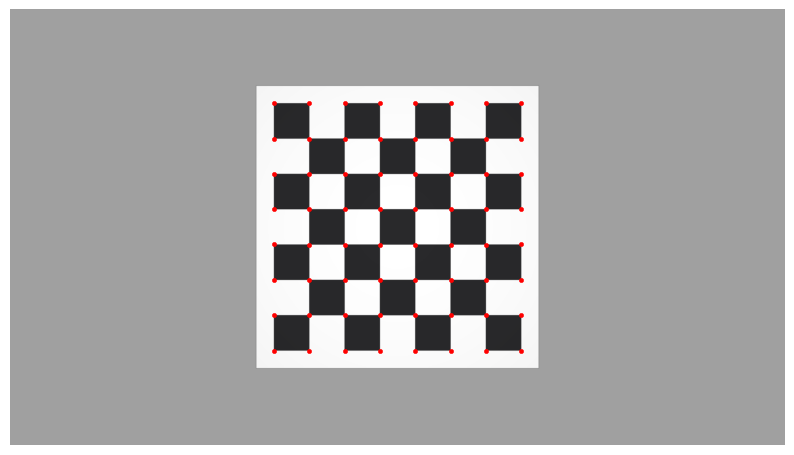

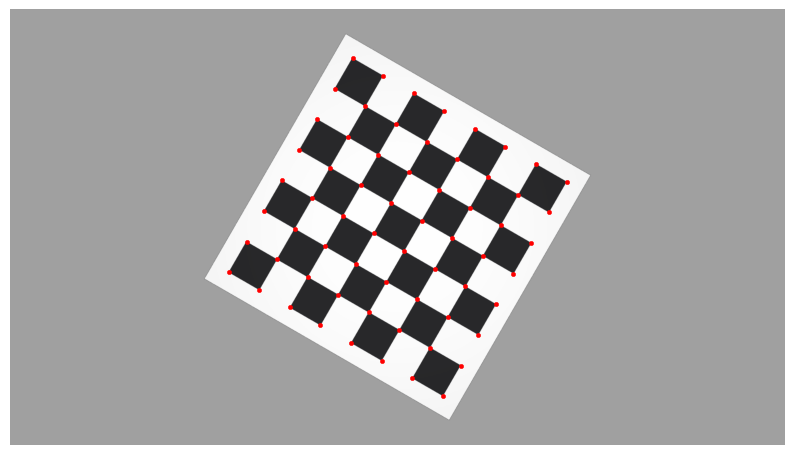

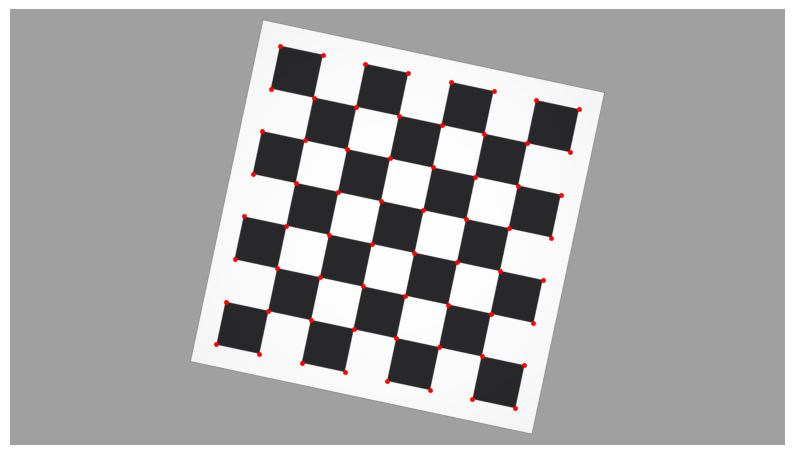

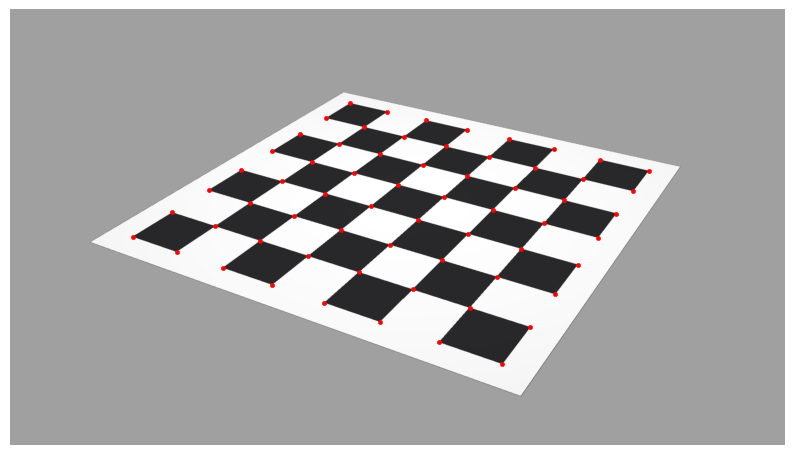

In [54]:
def plot_keypoints(img, keypoints):
    """Plot keypoints on an image

    Args:
        img (numpy): Image to plot keypoints on
        keypoints (list/array): Keypoints to plot
    """
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.scatter(keypoints[:,0], keypoints[:,1], c='r', s=10)
    plt.axis('off')
    plt.show()

plot_keypoints(img00c, keypoints_00)
plot_keypoints(img01c, keypoints_01)
plot_keypoints(img02c, keypoints_02)
plot_keypoints(img03c, keypoints_03)

## Compute Homography

Implement the function:

H = computeHomography(features, matches, model)

where model can be ('Euclidean', 'Similarity', 'Affine', 'Porjective')

follow your notes from MIRA lessons, don't use any opencv existing function

In [55]:
def computeHomography(features, matches, model):
    """
    Compute the homography matrix based on the transformation model.

    Parameters:
        features: points from source images
        matches: matched points in destination images
        model: The transformation model ('Euclidean', 'Similarity', 'Affine', 'Projective').

    Returns:
        H: The computed homography matrix.
    """
    
    if model == 'Euclidean':
            # Euclidean: [R | t], rigid transformation
            A = []
            b = []
            for (x, y), (x_d, y_d) in zip(features, matches):
                A.append([x, -y, 1, 0])
                A.append([y, x, 0, 1])
                b.extend([x_d, y_d])
            A = np.array(A)
            b = np.array(b)
            params = np.linalg.lstsq(A, b, rcond=None)[0]
            cos_theta, sin_theta, tx, ty = params
            R = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])
            t = np.array([[tx], [ty]])
            H = np.vstack([np.hstack([R, t]), 
                           [0, 0, 1]])

    elif model == 'Similarity':
        # Similarity: [sR | t]
        A = []
        b = []
        for (x, y), (x_d, y_d) in zip(features, matches):
            A.append([x, -y, 1, 0])
            A.append([y, x, 0, 1])
            b.extend([x_d, y_d])
        A = np.array(A)
        b = np.array(b)
        params = np.linalg.lstsq(A, b, rcond=None)[0]
        s_cos_theta, s_sin_theta, tx, ty = params
        R = np.array([[s_cos_theta, -s_sin_theta], [s_sin_theta, s_cos_theta]])
        t = np.array([[tx], [ty]])
        H = np.vstack([np.hstack([R, t]), 
                       [0, 0, 1]])
        
    elif model == 'Affine':
        # Affine: [A | t]
        A = []
        b = []
        for (x, y), (x_d, y_d) in zip(features, matches):
            A.append([x, y, 0, 0, 1, 0])
            A.append([0, 0, x, y, 0, 1])
            b.extend([x_d, y_d])
        A = np.array(A)
        b = np.array(b)
        params = np.linalg.lstsq(A, b, rcond=None)[0]
        a, b, c, d, tx, ty = params
        H = np.array([[a, b, tx], 
                      [c, d, ty], 
                      [0, 0, 1]])
    
    elif model == 'Projective':
        # Projective: [H]
        A = []
        b = []
        for (x, y), (x_d, y_d) in zip(features, matches):
            A.append([x, y, 1, 0, 0, 0, -x*x_d, -y*x_d])
            A.append([0, 0, 0, x, y, 1, -x*y_d, -y*y_d])
            b.extend([x_d, y_d])
        A = np.array(A)
        b = np.array(b)
        params = np.linalg.lstsq(A, b, rcond=None)[0]
        a, b, c, d, e, f, g, h = params
        H = np.array([[a, b, c], 
                      [d, e, f], 
                      [g, h, 1]])

    return H.astype(np.float32)

In [56]:
def show_multiple_images(images, titles, cols=1):
    """
    Display multiple images in one plot.

    Parameters:
        images: list of images to display
        titles: list of titles for each image
    """
    fig, axs = plt.subplots(cols, len(images) // cols, figsize=(20, 20))
    axs = axs.flatten()
    for i, (img, title) in enumerate(zip(images, titles)):
        axs[i].imshow(img)
        axs[i].set_title(title)
        axs[i].axis('off')
    plt.show()

##Compute Eucliedean Homography

Compute the Euclidean Homography between all loaded images

After computing them use the function `cv2.warpPerspective` to check the obtainen result

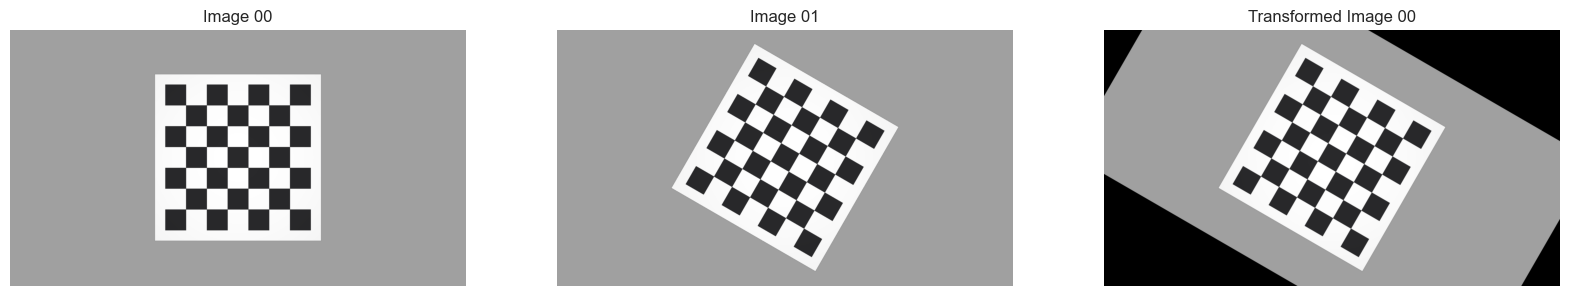

In [39]:
H_euclidean = computeHomography(keypoints_00, keypoints_01, 'Euclidean')
transformed_img = cv2.warpPerspective(img00c, H_euclidean, (img00c.shape[1], img00c.shape[0]))
show_multiple_images([img00c, img01c, transformed_img], ['Image 00', 'Image 01', 'Transformed Image 00'])

##Compute Similarity Homography
Compute the Similarity Homography between all loaded images

After computing them use the function `cv2.warpPerspective` to check the obtainen result

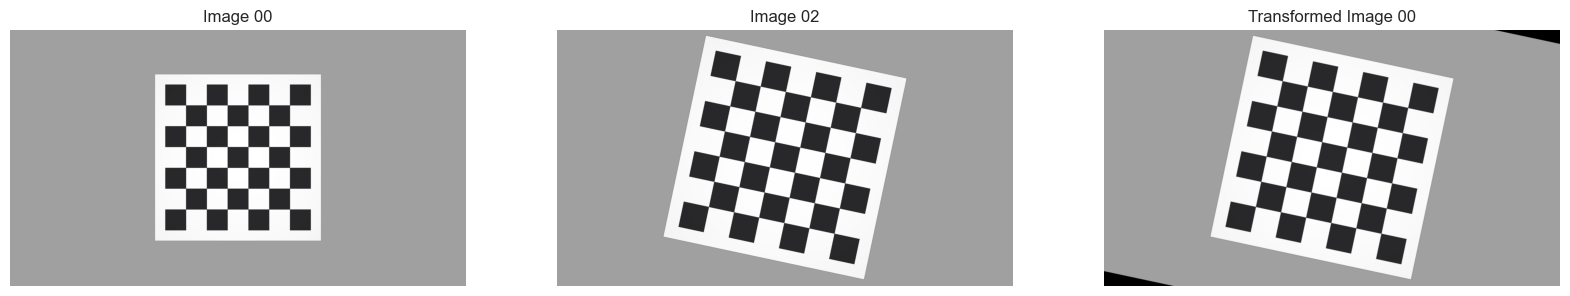

In [38]:
H_similarity = computeHomography(keypoints_00, keypoints_02, 'Similarity')
transformed_img = cv2.warpPerspective(img00c, H_similarity, (img00c.shape[1], img00c.shape[0]))
show_multiple_images([img00c, img02c, transformed_img], ['Image 00', 'Image 02', 'Transformed Image 00'])

##Compute Affine Homography

Compute the Affine Homography between all loaded images

After computing them use the function `cv2.warpPerspective` to check the obtainen result

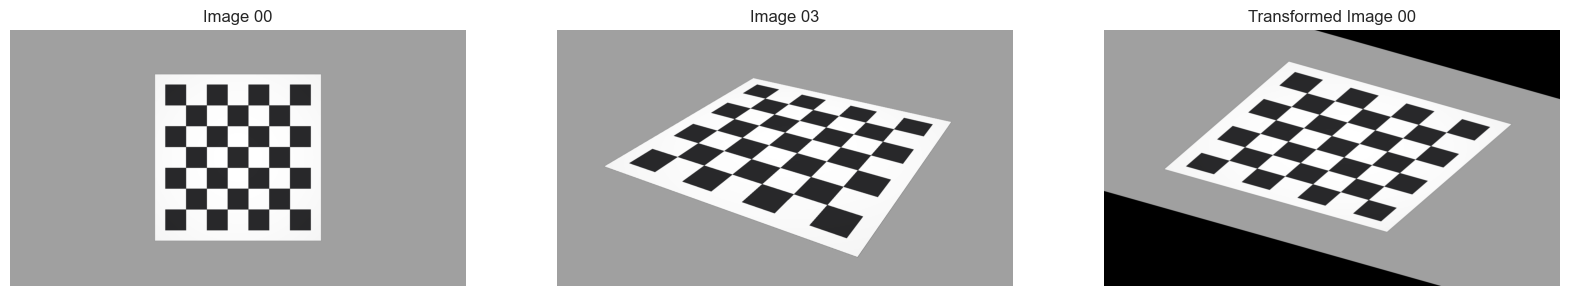

In [37]:
H_affine = computeHomography(keypoints_00, keypoints_03, 'Affine')
transformed_img = cv2.warpPerspective(img00c, H_affine, (img00c.shape[1], img00c.shape[0]))
show_multiple_images([img00c, img03c, transformed_img], ['Image 00', 'Image 03', 'Transformed Image 00'])

##Compute Projective Homography

Compute the Euclidean Homography between all loaded images

After computing them use the function `cv2.warpPerspective` to check the obtainen result

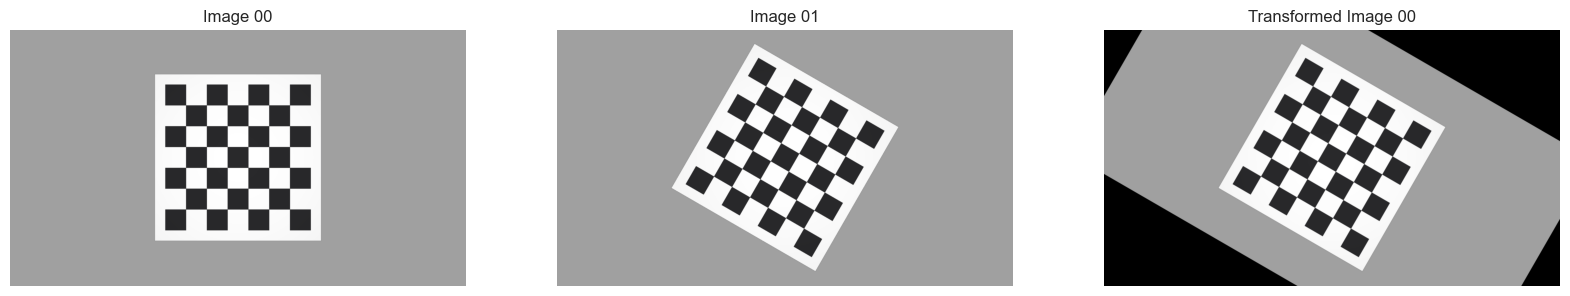

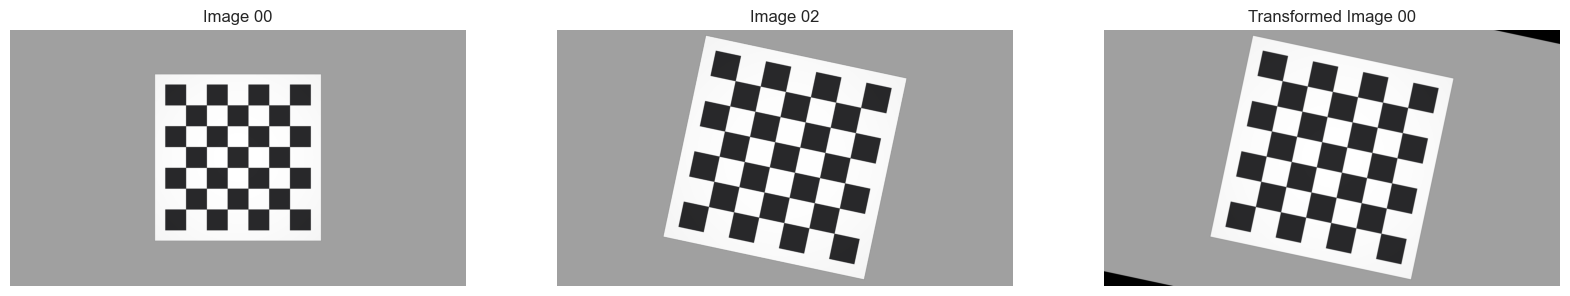

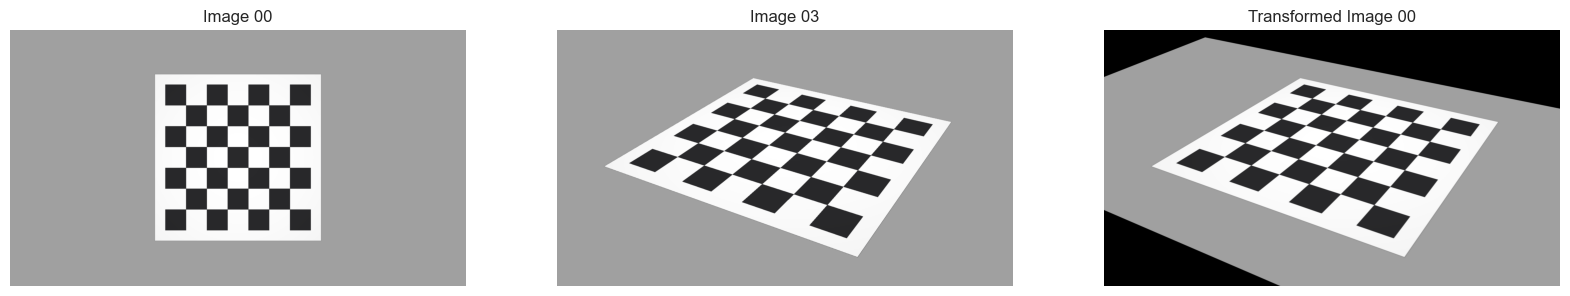

In [33]:
H_projective = computeHomography(keypoints_00, keypoints_01, 'Projective')
transformed_img = cv2.warpPerspective(img00c, H_projective, (img00c.shape[1], img00c.shape[0]))
show_multiple_images([img00c, img01c, transformed_img], ['Image 00', 'Image 01', 'Transformed Image 00'])

H_projective = computeHomography(keypoints_00, keypoints_02, 'Projective')
transformed_img = cv2.warpPerspective(img00c, H_projective, (img00c.shape[1], img00c.shape[0]))
show_multiple_images([img00c, img02c, transformed_img], ['Image 00', 'Image 02', 'Transformed Image 00'])

H_projective = computeHomography(keypoints_00, keypoints_03, 'Projective')
transformed_img = cv2.warpPerspective(img00c, H_projective, (img00c.shape[1], img00c.shape[0]))
show_multiple_images([img00c, img03c, transformed_img], ['Image 00', 'Image 03', 'Transformed Image 00'])

##Comment the previous obtained results.

Which is the best homography for each image pair? Why?

$\color{red}{\text{ANSWER}}$

## Compute Homography with skin images

Now Compute the Homography between the 2 skin images used during the first sesion using your Homography Computation function. Use all models and and compare the results

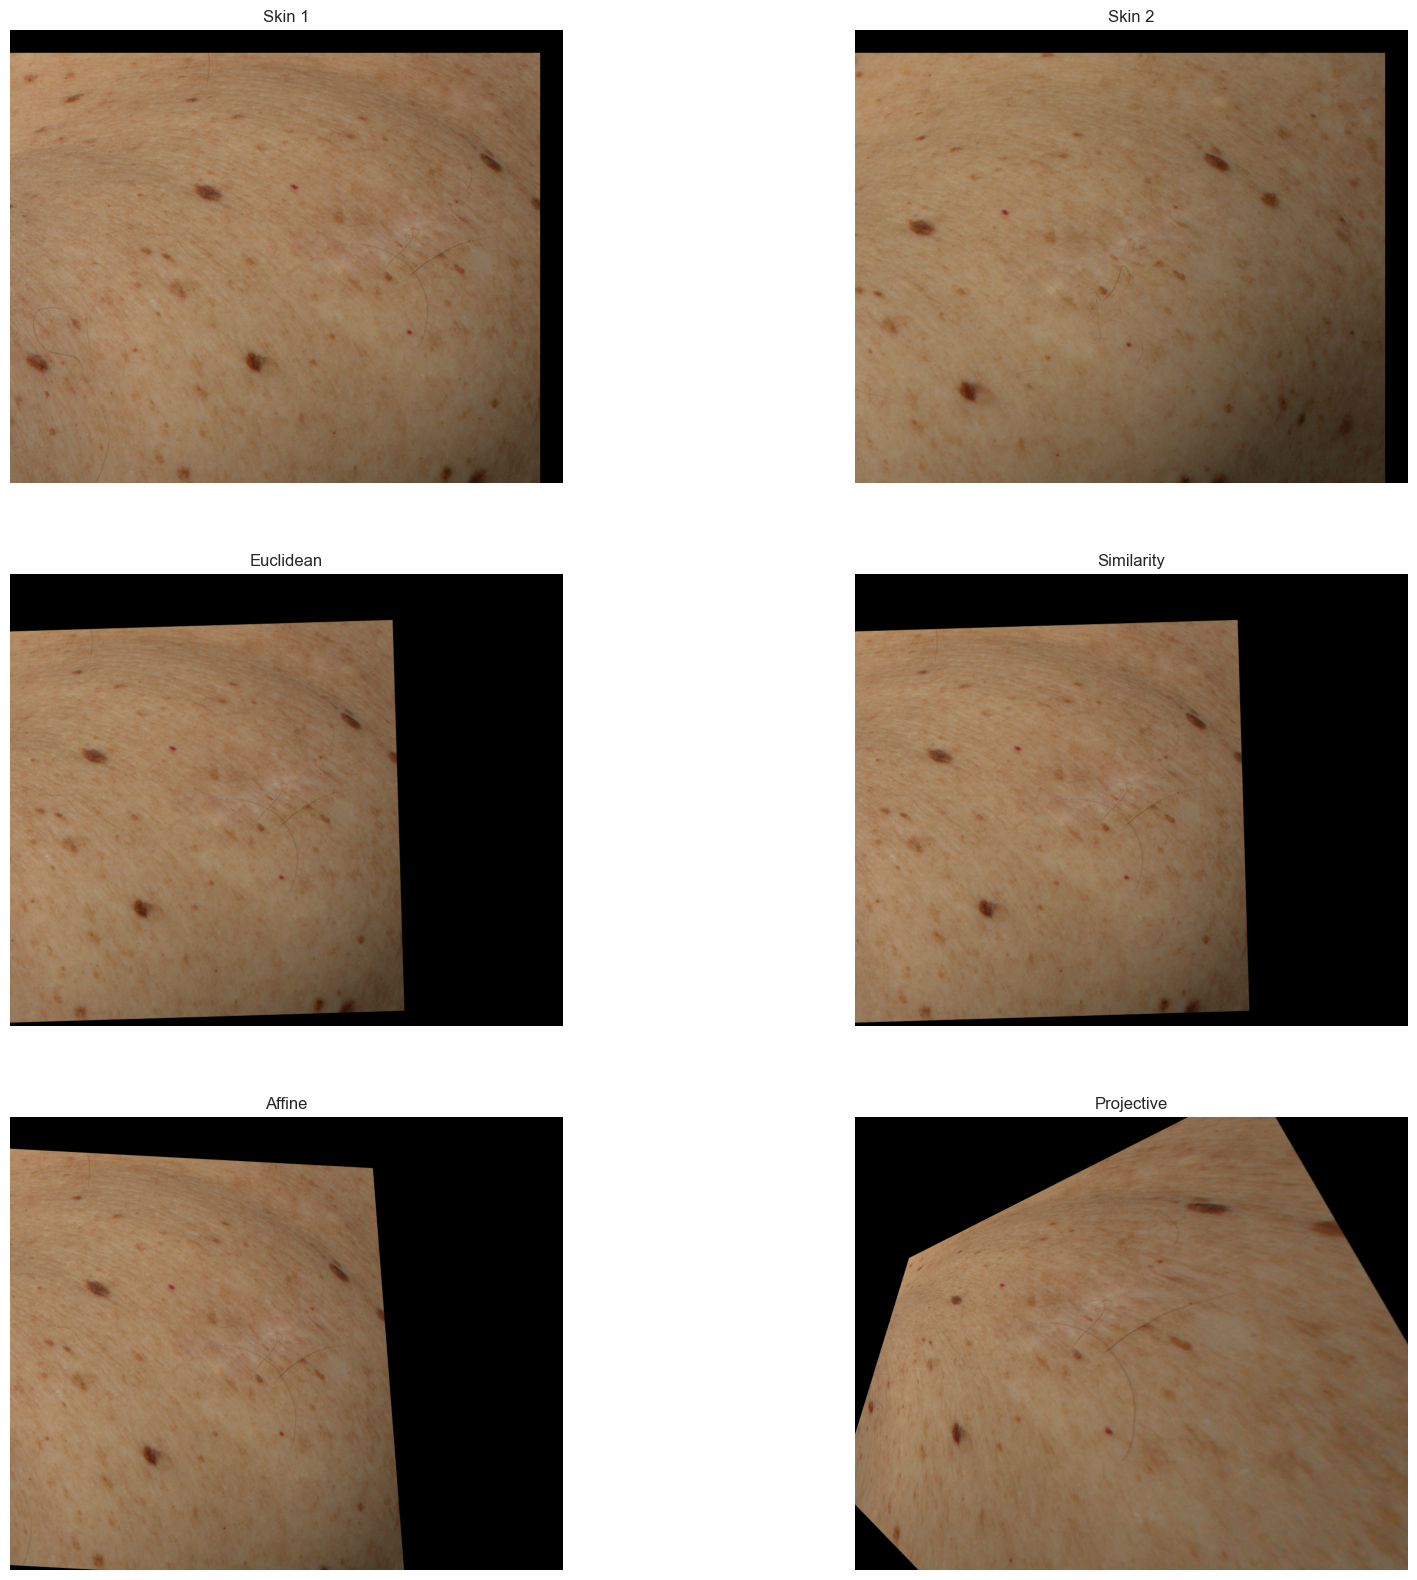

In [57]:
## get corresponding keypoints from matched keypoints
kp1_points = []
kp2_points = []
for match in matched_keypoints:
    kp1_points.append(kp1[match[0].queryIdx].pt)
    kp2_points.append(kp2[match[0].trainIdx].pt)

## convert to numpy array
kp1_points = np.array(kp1_points)
kp2_points = np.array(kp2_points)

## compute homography
H_euclidean = computeHomography(kp1_points, kp2_points, 'Euclidean')
H_similarity = computeHomography(kp1_points, kp2_points, 'Similarity')
H_affine = computeHomography(kp1_points, kp2_points, 'Affine')
H_projective = computeHomography(kp1_points, kp2_points, 'Projective')

## warp the images
h,w = skin_2.shape[:2]
transformed_euclidean = cv2.warpPerspective(skin_1, H_euclidean, (w, h))
transformed_similarity = cv2.warpPerspective(skin_1, H_similarity, (w, h))
transformed_affine = cv2.warpPerspective(skin_1, H_affine, (w, h))
transformed_projective = cv2.warpPerspective(skin_1, H_projective, (w, h))

## Plot the images
show_multiple_images([skin_1, skin_2, transformed_euclidean, transformed_similarity, transformed_affine, transformed_projective], 
                    ['Skin 1', 'Skin 2', 'Euclidean', 'Similarity', 'Affine', 'Projective'], cols=3)

## You should notice that you have outliers when you compute the Homography.

Implement RANSAC function and recompute all the Homographies using it.

Finally Warp one of the images and compare your results with the ones obtained using opencv functions.

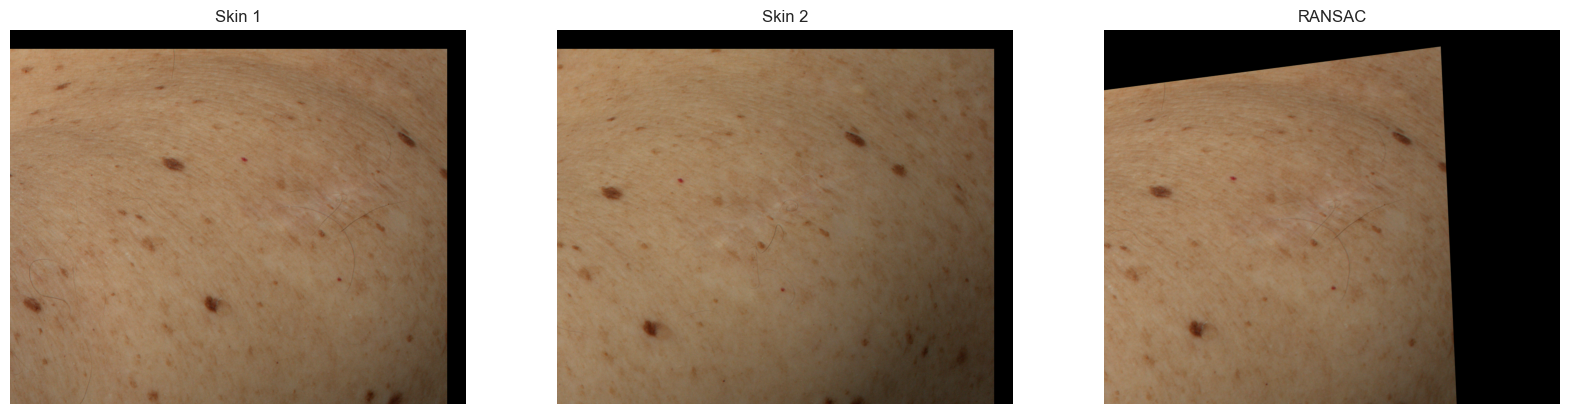

In [77]:
## RANSAC implementation
def RANSAC(features, matches, model, iterations=9, threshold=3.0):
    """
    RANSAC algorithm for robust homography estimation.

    Parameters:
        features: points from source images numpy array
        matches: matched points in destination images numpy array
        model: The transformation model ('Euclidean', 'Similarity', 'Affine', 'Projective').
        iterations: Number of iterations to run RANSAC.
        threshold: Distance threshold to consider a point as an inlier.

    Returns:
        best_H: The best homography matrix found.
        inliers: List of inlier matches.
    """
    best_H = None
    max_inliers = 0
    inliers = []

    for _ in range(iterations):
        # Randomly select a subset of points (4 for projective, 3 otherwise)
        subset_size = 4 if model == 'Projective' else 3
        idx = np.random.choice(len(features), subset_size, replace=False)

        src_pts = features[idx]
        dst_pts = matches[idx]

        # Compute homography for the sampled points
        H = computeHomography(src_pts, dst_pts, model)

        # Calculate inliers
        current_inliers = []
        for i in range(len(features)):
            src_pt = np.array([features[i][0], features[i][1], 1.0])  # Homogeneous coordinates
            dst_estimated = np.dot(H, src_pt)
            dst_estimated /= dst_estimated[2]  # Normalize

            # Calculate distance
            distance = np.linalg.norm(dst_estimated[:2] - matches[i])
            if distance < threshold:
                current_inliers.append(i)

        # Update the best homography if this iteration has more inliers
        if len(current_inliers) > max_inliers:
            max_inliers = len(current_inliers)
            best_H = H
            inliers = current_inliers

    return best_H, inliers

H_ransac, inliers = RANSAC(kp1_points, kp2_points, 'Projective', iterations=17, threshold=3.0)
transformed_ransac = cv2.warpPerspective(skin_1, H_ransac, (w, h))

## Plot the images
show_multiple_images([skin_1, skin_2, transformed_ransac], 
                    ['Skin 1', 'Skin 2', 'RANSAC'], cols=1)